# DSCI 619 - Deep Learning, Project 4

### *Jeffery Boczkaja*

## 1. Load the beans dataset

In [1]:
#import tensorflow as tf
import tensorflow.compat.v2 as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from __future__ import absolute_import, division, print_function, unicode_literals
from collections import Counter
# Enable eager execution
tf.enable_v2_behavior()

In [2]:
import tensorflow_datasets as tfds

(bn_train, bn_validation, bn_test),bn_info = tfds.load(

    name = 'beans',

    split = ['train', 'validation', 'test'],

    as_supervised = True,

    with_info = True)

print(bn_info)

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by
    experts from the National Crops Resources Research Institute (NaCRRI) in Uganda
    and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_dir='C:\\Users\\whitl\\tensorflow_datasets\\beans\\0.1.0',
    file_format=tfrecord,
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
        '

## 2. Split the data into a training and a test dataset

In [3]:
# the training dataset has features/image and label/target
for image, label in bn_train.take(1):  # example is (image, label)
  print(image.shape, label)

(500, 500, 3) tf.Tensor(1, shape=(), dtype=int64)


In [4]:
print(bn_info.features["label"].num_classes)
print(bn_info.features["label"].names)

3
['angular_leaf_spot', 'bean_rust', 'healthy']


In [5]:
print(bn_info.features.shape)
print(bn_info.features.dtype)
print(bn_info.features['image'].shape)
print(bn_info.features['image'].dtype)

{'image': (500, 500, 3), 'label': ()}
{'image': tf.uint8, 'label': tf.int64}
(500, 500, 3)
<dtype: 'uint8'>


In [6]:
# Image parameters:
image_height = 500
image_width = 500
num_channels = 3 # RGB
num_classes = 3 # healthy, angular leaf spot disease, bean rust disease

# Pipeline hyperparameters:
batch_size = 32

# Let's keep the dimensions the same (no resizing for now)
# the inputs are the image, label and target size
def normalize_image(image, label, target_height = 500, target_width = 500):
    """Normalizes images: `unit8` -> `float32` and resizes images
    by keeping the aspect ratio the same without distortion."""
    image = tf.cast(image, tf.float32)/255.
    image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)
    return image, label
#apply normalize_image() function to each of image avoid writing a loop
bn_train = bn_train.map(normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
bn_train = bn_train.cache().shuffle(1000)
bn_train = bn_train.shuffle(bn_info.splits['train'].num_examples)
bn_train = bn_train.batch(batch_size)
bn_train = bn_train.prefetch(tf.data.experimental.AUTOTUNE)


In [7]:
bn_validation = bn_validation.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
bn_validation = bn_validation.batch(batch_size)
bn_validation = bn_validation.cache()
bn_validation = bn_validation.prefetch(tf.data.experimental.AUTOTUNE)

bn_test = bn_test.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
bn_test = bn_test.batch(batch_size)
bn_test = bn_test.cache()
bn_test = bn_test.prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
def return_class_labels(ds):
    """"Returns a list of class labels from a `DatasetV1Adapter` object."""
    l_labels = []
    # since we handle labels only in this funciton, we discard the first parameter that is image
    # we take out one batch that is 32 images and lables
    for _, labels in ds.take(-1):
        labels = labels.numpy()
        l_labels.append(labels[:])
    # the l_labels is a nest of list , for example [ [1, 0, 2, ...], [2,1, 1,..], ..]
    # return a single list by using list comprehension
    #[1, 0, 2, ..., 2, 1, 1, ..]
    return [item for sublist in l_labels for item in sublist]

training_labels = return_class_labels(bn_train)
print("The distribution of training labels is: ", (Counter(training_labels)))

validation_labels = return_class_labels(bn_validation)
print("The distribution of validation labels is: ", (Counter(validation_labels)))

test_labels = return_class_labels(bn_test)
print("The distribution of test labels is: ", (Counter(test_labels)))

The distribution of training labels is:  Counter({1: 348, 0: 345, 2: 341})
The distribution of validation labels is:  Counter({1: 45, 2: 44, 0: 44})
The distribution of test labels is:  Counter({0: 43, 1: 43, 2: 42})


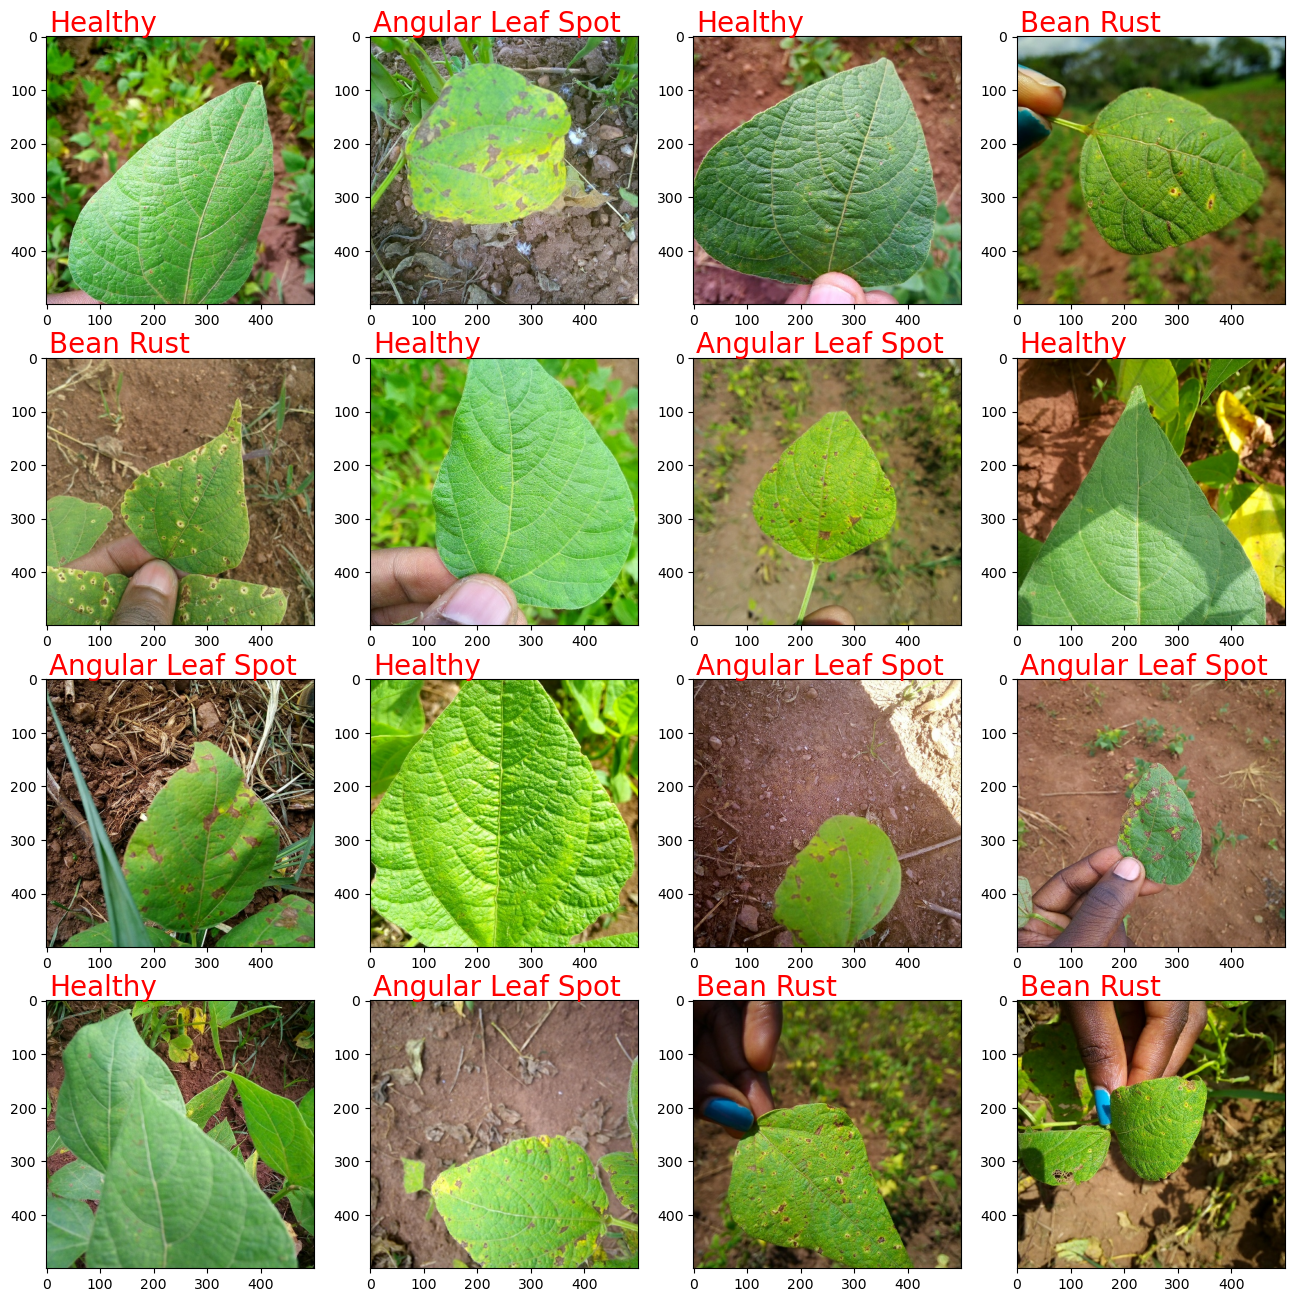

In [9]:
# take out one batch that is 32 images
example = bn_train.take(1)
# each batch has two componets, image and label
# sample=(image, lable)
for sample in example:
    image, label = sample[0], sample[1]
    #convert them to np
    image = image.numpy()
    label = label.numpy()

n_cols, n_rows = 4, 4
plt.rcParams['figure.figsize'] = [n_cols*4, n_rows*4]

fig = plt.figure()
for i in range(1, n_cols*n_rows + 1):
    ax = fig.add_subplot(n_rows, n_cols,i)
    # we label the subplots using names instead of magic numbers such as 0, 1 and 2
    ax.text(5, -9, "Angular Leaf Spot" if label[i] == 0 else "Bean Rust" if label[i] == 1 else "Healthy",
            color = 'red', fontsize = 20)
    ax.imshow(image[i, :, :, :], cmap = plt.get_cmap("jet"))  

In [10]:
for images, labels in bn_train.take(1):
    print("Images batch shape: ", images.shape)
    print("Labels batch shape: ", labels.shape)

Images batch shape:  (32, 500, 500, 3)
Labels batch shape:  (32,)


In [11]:
num_train_examples = bn_info.splits['train'].num_examples
num_validation_examples = bn_info.splits['validation'].num_examples
num_test_examples = bn_info.splits['test'].num_examples

print("Number of training examples:   ", num_train_examples)
print("Number of validation examples: ", num_validation_examples)
print("Number of test examples:       ", num_test_examples)

Number of training examples:    1034
Number of validation examples:  133
Number of test examples:        128


## 3. Build a CNN network to perform image classification using TensorFlow

In [12]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)

In [13]:
num_labels = bn_info.features["label"].num_classes
print(f'There are {num_labels} classes in the image dataset')
image_channel = 3
print(f' There are {image_channel} channels in the images')
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, image_channel)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_labels)
])

There are 3 classes in the image dataset
 There are 3 channels in the images


In [14]:
# Let's summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 500, 500, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 500, 500, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 250, 250, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 125, 125, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 64)      1

In [15]:
# Compile the model: set optimizer, define loss function, and specify metrics for evaluation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [16]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 3)
epochs= 20
history = model.fit(
  bn_train,
  validation_data=bn_validation,
  epochs=epochs,
  callbacks=[callback], verbose = 1
)

Epoch 1/20
33/33 [==============================] - 124s 3s/step - loss: 1.1010 - accuracy: 0.3308 - val_loss: 1.0986 - val_accuracy: 0.3308
Epoch 2/20
33/33 [==============================] - 94s 3s/step - loss: 1.0987 - accuracy: 0.3317 - val_loss: 1.0986 - val_accuracy: 0.3383
Epoch 3/20
33/33 [==============================] - 93s 3s/step - loss: 1.0987 - accuracy: 0.3366 - val_loss: 1.0986 - val_accuracy: 0.3383
Epoch 4/20
33/33 [==============================] - 91s 3s/step - loss: 1.0987 - accuracy: 0.3366 - val_loss: 1.0986 - val_accuracy: 0.3383
Epoch 5/20
33/33 [==============================] - 92s 3s/step - loss: 1.0988 - accuracy: 0.3366 - val_loss: 1.0986 - val_accuracy: 0.3383
CPU times: total: 25min 58s
Wall time: 8min 13s


### Evaluate the Model

In [17]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(bn_test, verbose=0)
print(f' The test loss ={test_loss:.2f} and test accuracy = {test_acc:.2f}')

 The test loss =1.10 and test accuracy = 0.34


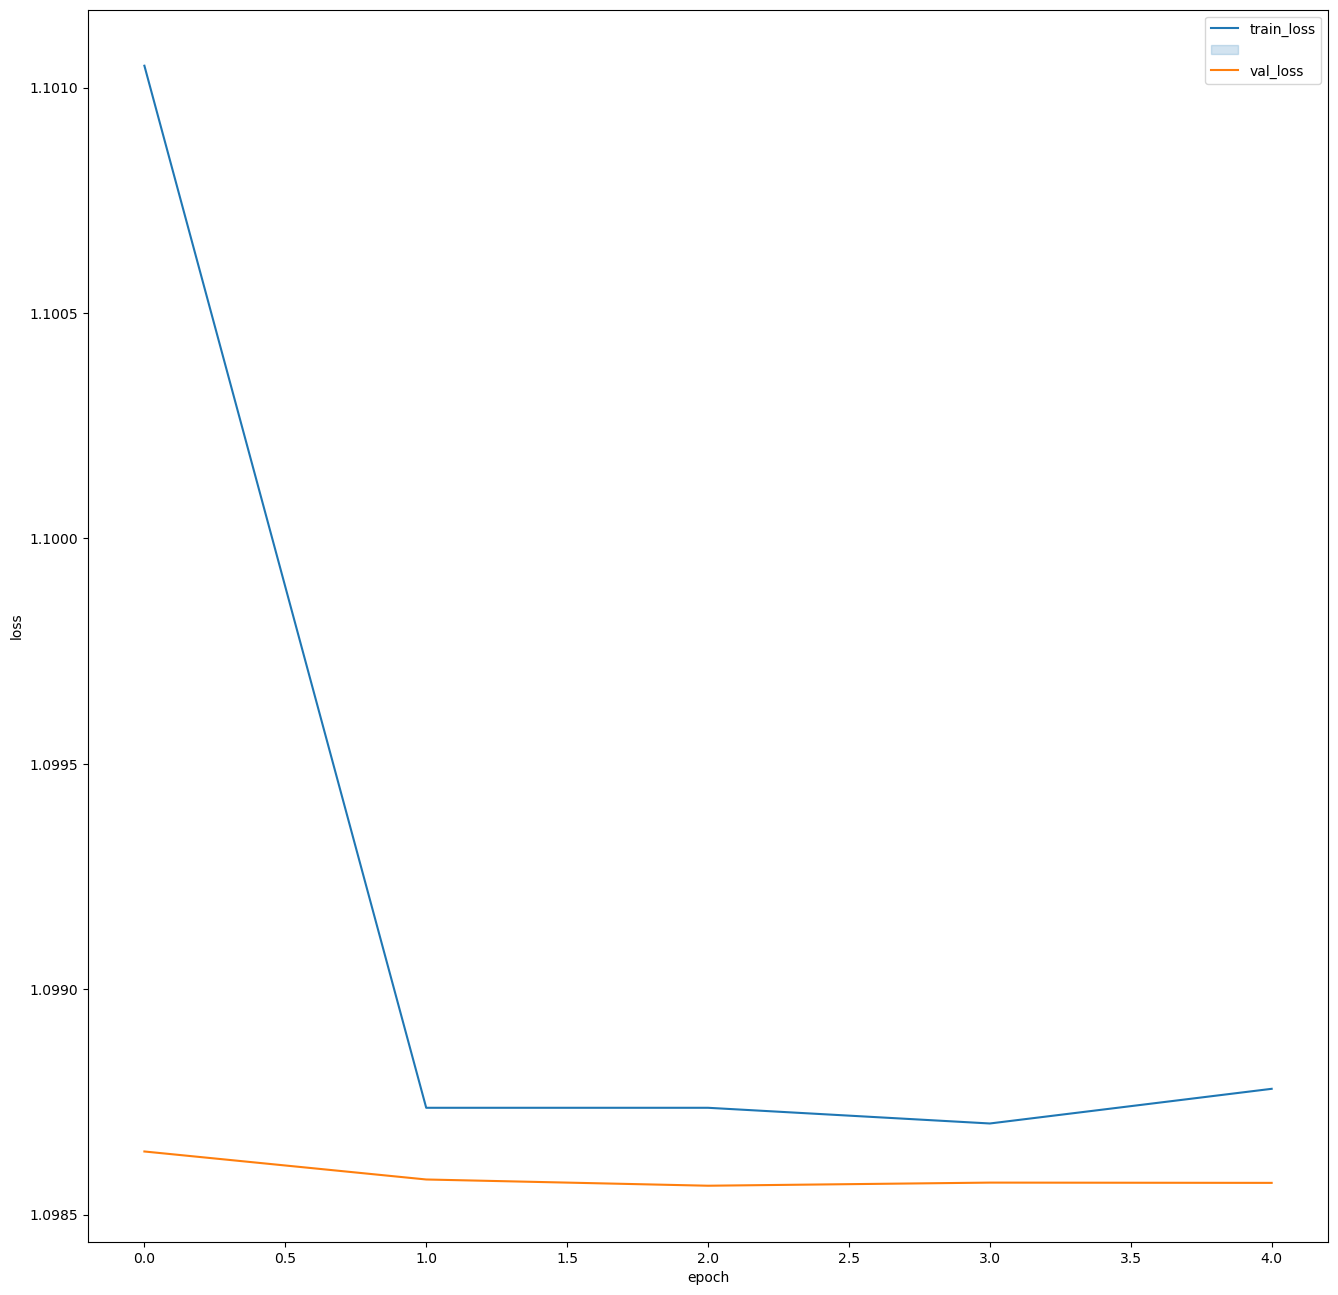

In [18]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
#Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
#Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
#Add legends
plt.legend(labels=['train_loss', '', 'val_loss'])

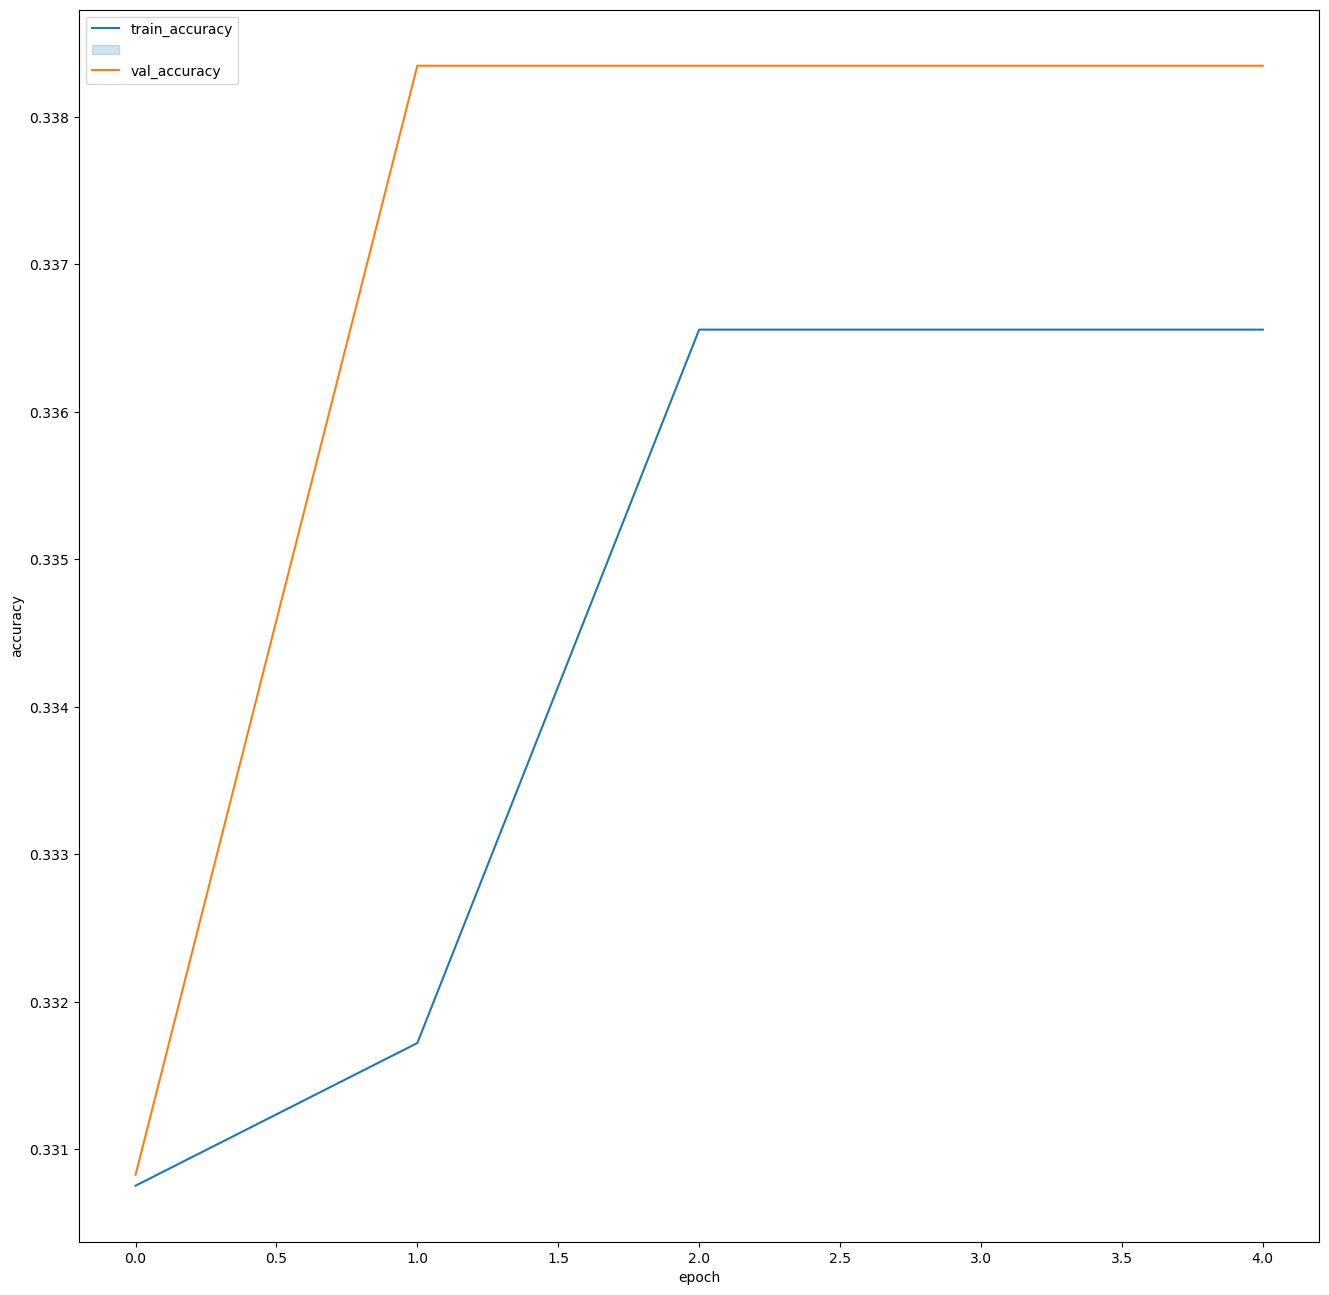

In [19]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
#Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
#Add legends
plt.legend(labels=['train_accuracy', '', 'val_accuracy'])

### Does it overfit or underfit the data? We will justify our answer.

This model is underfitting the data because we have high initial training loss and then flattens out without decreasing. Also the validation loss is noticeably below the training loss.

## 4. Using data augmentation techniques to build a CNN network using TensorFlow with same network architecture

In [20]:
data_aug = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(image_height, 
                                                              image_width,
                                                              image_channel)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1,width_factor = 0.1 ),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.1, 0.1))
  ])

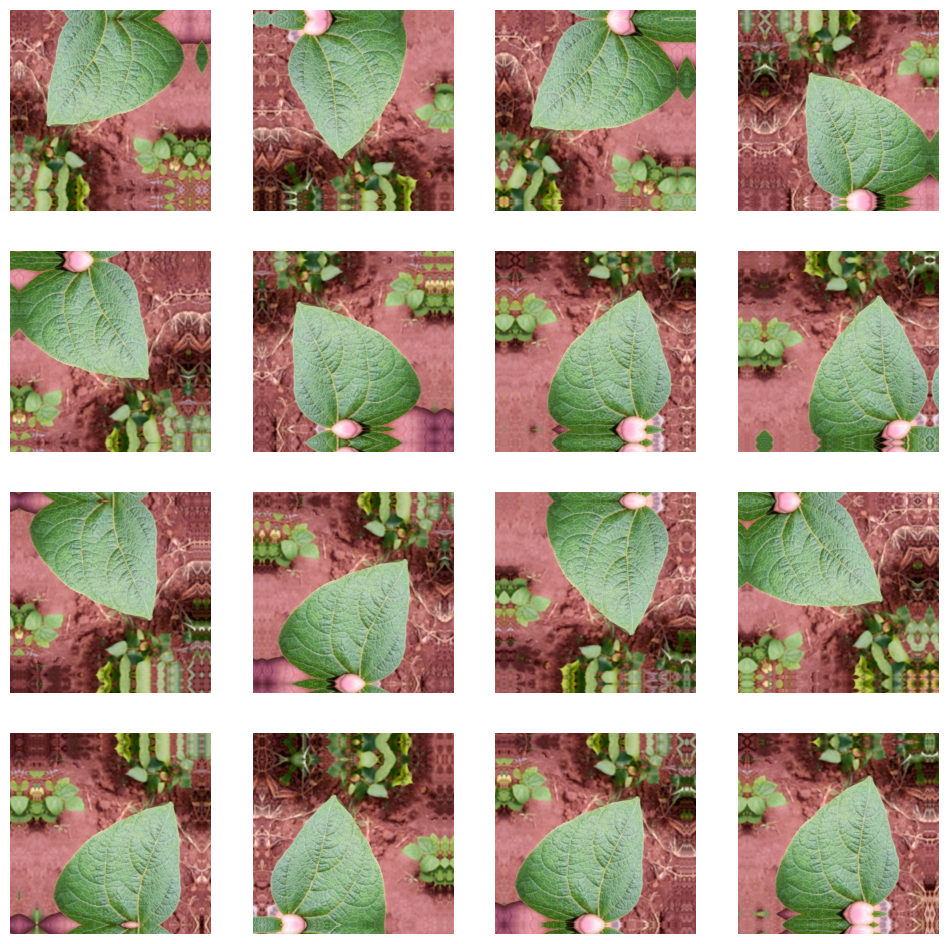

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for img, lab in bn_train.take(1):
    for i in range(16):
        aug_images = data_aug(img)
        # Convert back to uint8 and clip to ensure values are within the 0-255 range
        display_image = np.clip(aug_images[0].numpy() * 255, 0, 255).astype("uint8")
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(display_image)
        plt.axis("off")

In [22]:
model = tf.keras.Sequential([
  # Data augmentation
  data_aug,
  # Data normalization
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_labels)
])

In [23]:
# Compile the model: set optimizer, define loss function, and specify metrics for evaluation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 500, 500, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 500, 500, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 500, 500, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 250, 250, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 250, 250, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 125, 125, 32)      0         
 g2D)                                                 

### Train the Model

In [25]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 3)
epochs= 20
history = model.fit(
  bn_train,
  validation_data=bn_test,
  epochs=epochs,
  callbacks=[callback], verbose = 1
)

Epoch 1/20
33/33 [==============================] - 125s 4s/step - loss: 1.1016 - accuracy: 0.3008 - val_loss: 1.0986 - val_accuracy: 0.3359
Epoch 2/20
33/33 [==============================] - 115s 3s/step - loss: 1.0988 - accuracy: 0.3104 - val_loss: 1.0986 - val_accuracy: 0.3359
Epoch 3/20
33/33 [==============================] - 112s 3s/step - loss: 1.0986 - accuracy: 0.3298 - val_loss: 1.0986 - val_accuracy: 0.3281
Epoch 4/20
33/33 [==============================] - 112s 3s/step - loss: 1.0988 - accuracy: 0.2950 - val_loss: 1.0986 - val_accuracy: 0.3281
CPU times: total: 26min 57s
Wall time: 7min 45s


### Evaluate the model

In [26]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(bn_test, verbose=0)
print(f' The test loss ={test_loss:.2f} and test accuracy = {test_acc:.2f}')

 The test loss =1.10 and test accuracy = 0.33


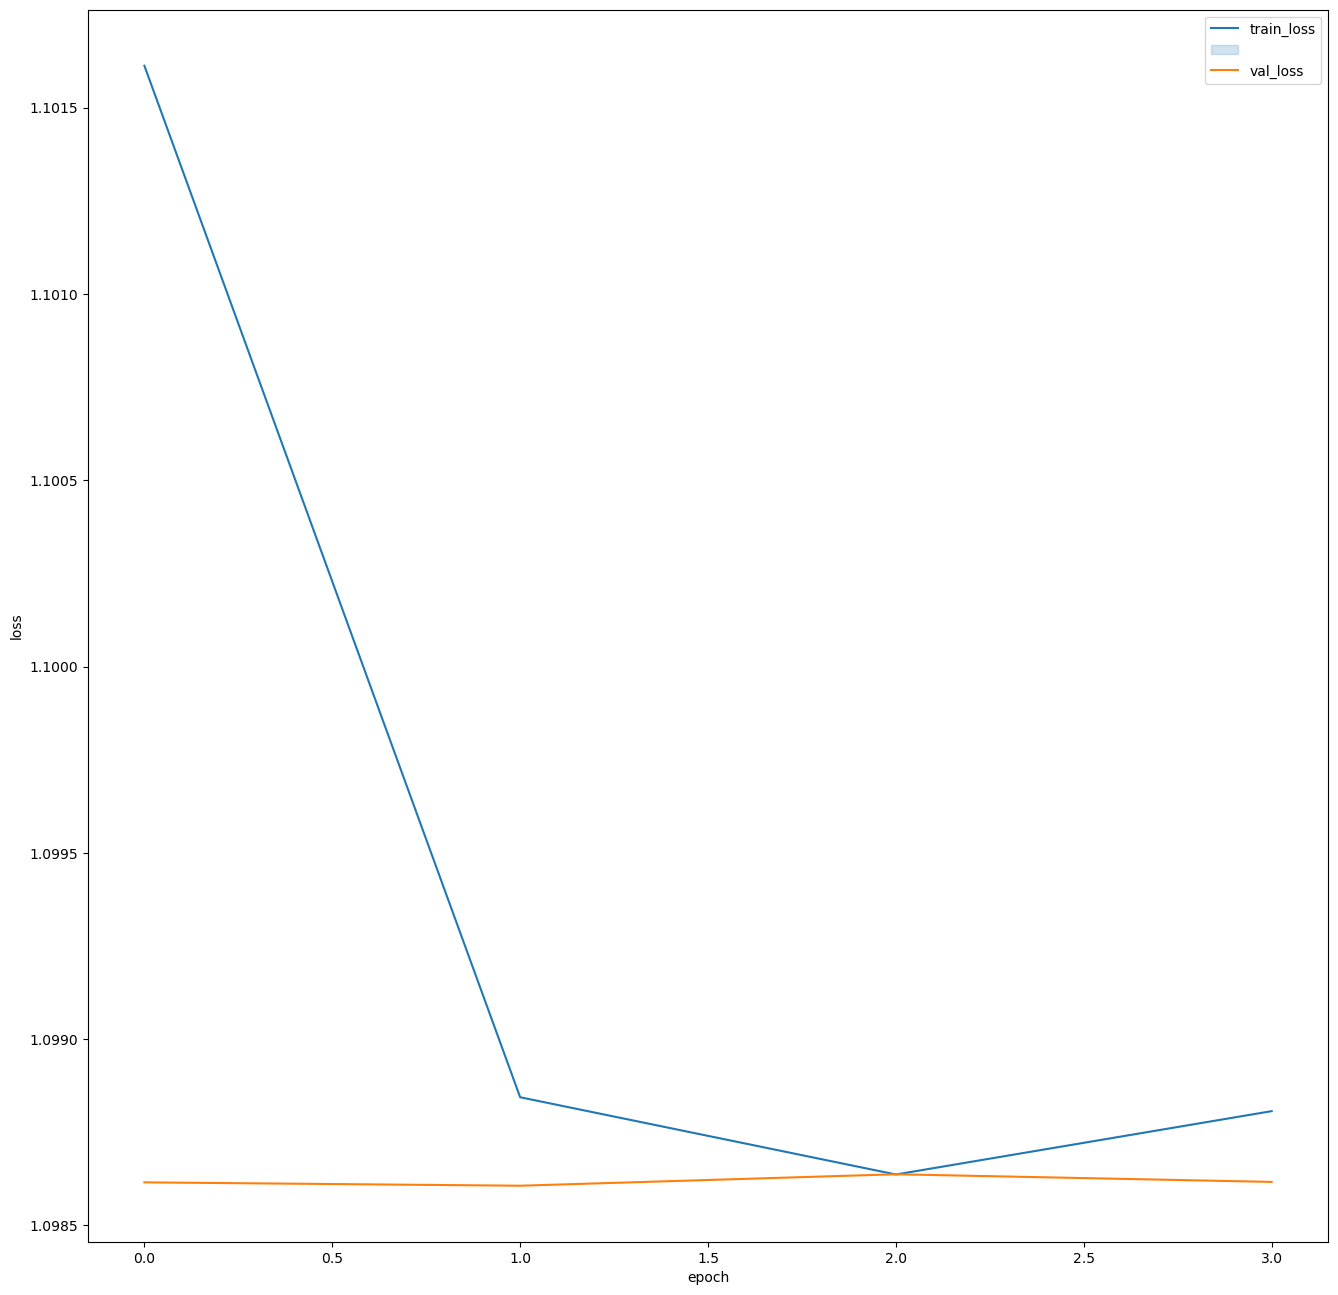

In [27]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
#Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
#Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
#Add legends
plt.legend(labels=['train_loss', '', 'val_loss'])

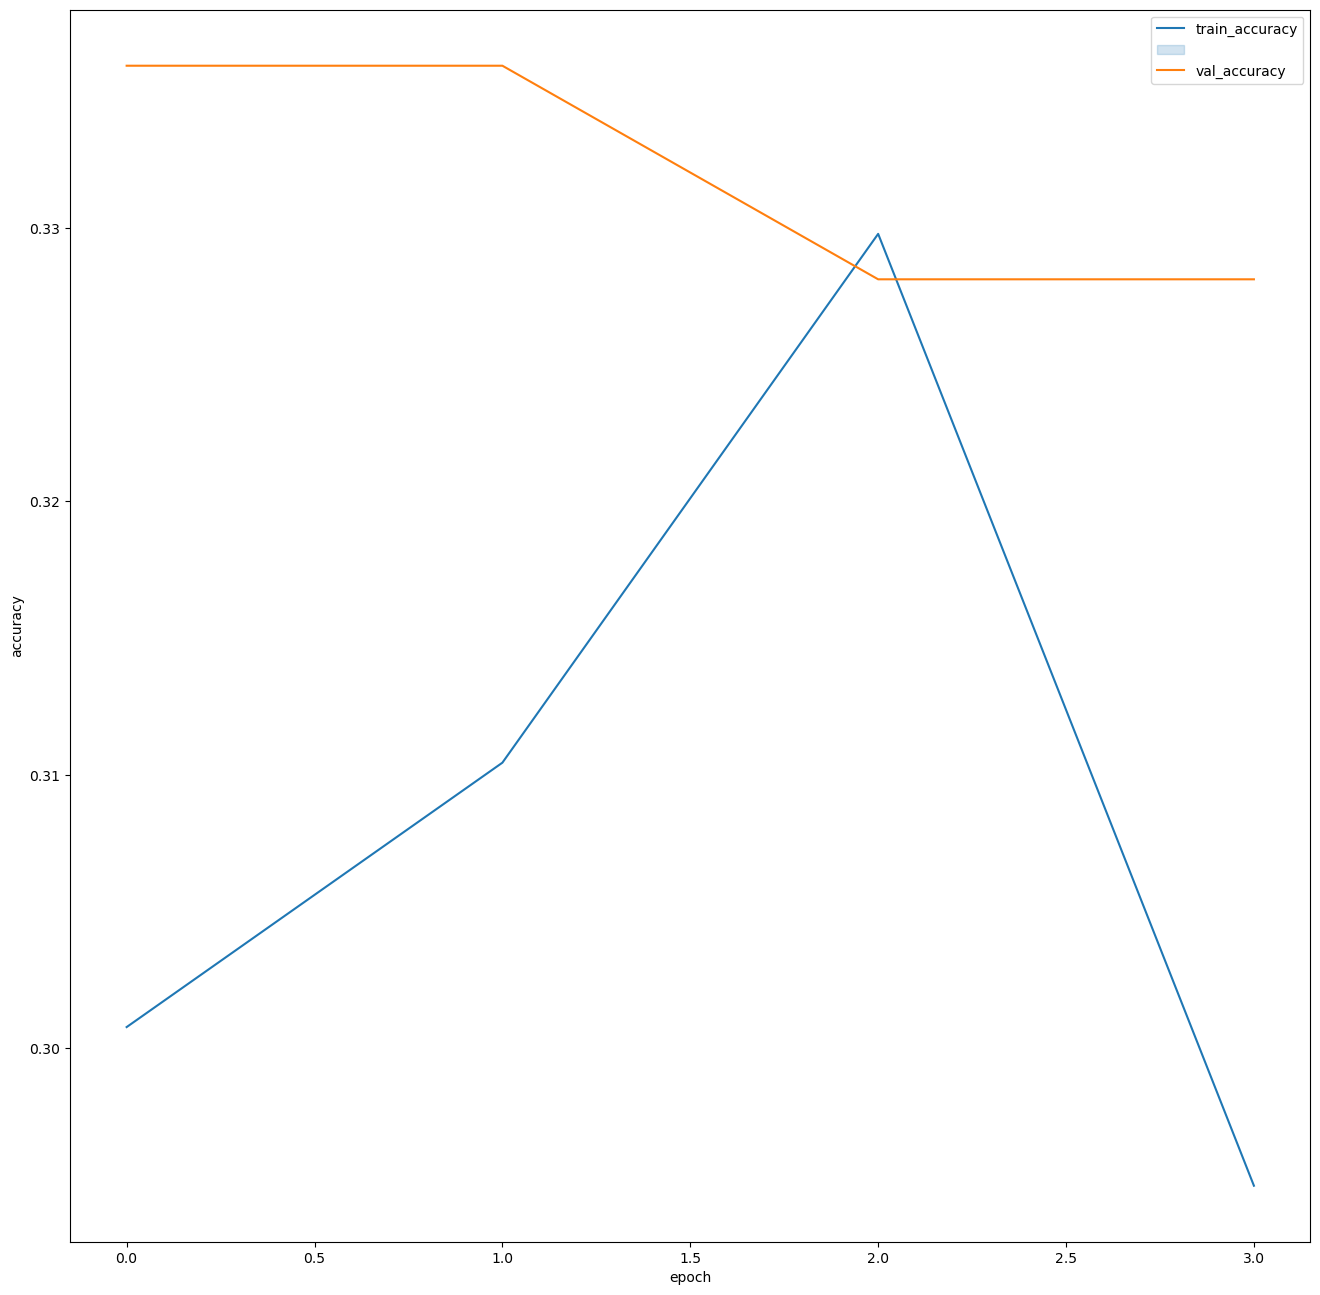

In [28]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
#Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
#Add legends
plt.legend(labels=['train_accuracy', '', 'val_accuracy'])

### Did it produce better performance on the test dataset?

This did not produce a better peformance on the test dataset. It is actually slightly worse than the first model!

## 5. Build a CNN network using transfer learning and TensorFlow by choosing a pre-trained model

In [29]:
# Specify the image size for our dataset
IMG_SHAPE = (image_height, image_width, image_channel)

MobileNetV3Large_model = tf.keras.applications.MobileNetV3Large(input_shape = IMG_SHAPE,
                                               include_top=False, # Remove the fully-connected layer
                                               weights='imagenet') # Pre-training on ImageNet

In [30]:
MobileNetV3Large_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500, 500, 3)]        0         []                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 500, 500, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 250, 250, 16)         432       ['rescaling_3[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 250, 250, 16)         64        ['Conv[0][0]']                
 lization)                                                                         

 (DepthwiseConv2D)                                                                                
                                                                                                  
 expanded_conv_2/depthwise/  (None, 125, 125, 72)         288       ['expanded_conv_2/depthwise[0]
 BatchNorm (BatchNormalizat                                         [0]']                         
 ion)                                                                                             
                                                                                                  
 re_lu_5 (ReLU)              (None, 125, 125, 72)         0         ['expanded_conv_2/depthwise/Ba
                                                                    tchNorm[0][0]']               
                                                                                                  
 expanded_conv_2/project (C  (None, 125, 125, 24)         1728      ['re_lu_5[0][0]']             
 onv2D)   

                                                                    Norm[0][0]']                  
                                                                                                  
 expanded_conv_4/depthwise   (None, 63, 63, 120)          3000      ['re_lu_9[0][0]']             
 (DepthwiseConv2D)                                                                                
                                                                                                  
 expanded_conv_4/depthwise/  (None, 63, 63, 120)          480       ['expanded_conv_4/depthwise[0]
 BatchNorm (BatchNormalizat                                         [0]']                         
 ion)                                                                                             
                                                                                                  
 re_lu_10 (ReLU)             (None, 63, 63, 120)          0         ['expanded_conv_4/depthwise/Ba
          

                                                                                                  
 re_lu_14 (ReLU)             (None, 1, 1, 120)            0         ['tf.math.add_3[0][0]']       
                                                                                                  
 tf.math.multiply_3 (TFOpLa  (None, 1, 1, 120)            0         ['re_lu_14[0][0]']            
 mbda)                                                                                            
                                                                                                  
 expanded_conv_5/squeeze_ex  (None, 63, 63, 120)          0         ['re_lu_13[0][0]',            
 cite/Mul (Multiply)                                                 'tf.math.multiply_3[0][0]']  
                                                                                                  
 expanded_conv_5/project (C  (None, 63, 63, 40)           4800      ['expanded_conv_5/squeeze_exci
 onv2D)   

 multiply_3 (Multiply)       (None, 32, 32, 200)          0         ['expanded_conv_7/expand/Batch
                                                                    Norm[0][0]',                  
                                                                     'tf.math.multiply_6[0][0]']  
                                                                                                  
 expanded_conv_7/depthwise   (None, 32, 32, 200)          1800      ['multiply_3[0][0]']          
 (DepthwiseConv2D)                                                                                
                                                                                                  
 expanded_conv_7/depthwise/  (None, 32, 32, 200)          800       ['expanded_conv_7/depthwise[0]
 BatchNorm (BatchNormalizat                                         [0]']                         
 ion)                                                                                             
          

                                                                                                  
 expanded_conv_9/expand (Co  (None, 32, 32, 184)          14720     ['expanded_conv_8/Add[0][0]'] 
 nv2D)                                                                                            
                                                                                                  
 expanded_conv_9/expand/Bat  (None, 32, 32, 184)          736       ['expanded_conv_9/expand[0][0]
 chNorm (BatchNormalization                                         ']                            
 )                                                                                                
                                                                                                  
 tf.math.add_10 (TFOpLambda  (None, 32, 32, 184)          0         ['expanded_conv_9/expand/Batch
 )                                                                  Norm[0][0]']                  
          

                                                                                                  
 multiply_10 (Multiply)      (None, 32, 32, 480)          0         ['expanded_conv_10/depthwise/B
                                                                    atchNorm[0][0]',              
                                                                     'tf.math.multiply_13[0][0]'] 
                                                                                                  
 expanded_conv_10/squeeze_e  (None, 1, 1, 480)            0         ['multiply_10[0][0]']         
 xcite/AvgPool (GlobalAvera                                                                       
 gePooling2D)                                                                                     
                                                                                                  
 expanded_conv_10/squeeze_e  (None, 1, 1, 120)            57720     ['expanded_conv_10/squeeze_exc
 xcite/Con

                                                                                                  
 expanded_conv_11/squeeze_e  (None, 1, 1, 672)            113568    ['expanded_conv_11/squeeze_exc
 xcite/Conv_1 (Conv2D)                                              ite/Relu[0][0]']              
                                                                                                  
 tf.math.add_17 (TFOpLambda  (None, 1, 1, 672)            0         ['expanded_conv_11/squeeze_exc
 )                                                                  ite/Conv_1[0][0]']            
                                                                                                  
 re_lu_28 (ReLU)             (None, 1, 1, 672)            0         ['tf.math.add_17[0][0]']      
                                                                                                  
 tf.math.multiply_17 (TFOpL  (None, 1, 1, 672)            0         ['re_lu_28[0][0]']            
 ambda)   

                                                                                                  
 re_lu_31 (ReLU)             (None, 1, 1, 672)            0         ['tf.math.add_20[0][0]']      
                                                                                                  
 tf.math.multiply_20 (TFOpL  (None, 1, 1, 672)            0         ['re_lu_31[0][0]']            
 ambda)                                                                                           
                                                                                                  
 expanded_conv_12/squeeze_e  (None, 16, 16, 672)          0         ['multiply_14[0][0]',         
 xcite/Mul (Multiply)                                                'tf.math.multiply_20[0][0]'] 
                                                                                                  
 expanded_conv_12/project (  (None, 16, 16, 160)          107520    ['expanded_conv_12/squeeze_exc
 Conv2D)  

 on)                                                                                              
                                                                                                  
 expanded_conv_13/Add (Add)  (None, 16, 16, 160)          0         ['expanded_conv_12/project/Bat
                                                                    chNorm[0][0]',                
                                                                     'expanded_conv_13/project/Bat
                                                                    chNorm[0][0]']                
                                                                                                  
 expanded_conv_14/expand (C  (None, 16, 16, 960)          153600    ['expanded_conv_13/Add[0][0]']
 onv2D)                                                                                           
                                                                                                  
 expanded_

 malization)                                                                                      
                                                                                                  
 tf.math.add_27 (TFOpLambda  (None, 16, 16, 960)          0         ['Conv_1/BatchNorm[0][0]']    
 )                                                                                                
                                                                                                  
 re_lu_38 (ReLU)             (None, 16, 16, 960)          0         ['tf.math.add_27[0][0]']      
                                                                                                  
 tf.math.multiply_27 (TFOpL  (None, 16, 16, 960)          0         ['re_lu_38[0][0]']            
 ambda)                                                                                           
                                                                                                  
 multiply_

In [31]:
tf.keras.utils.plot_model(MobileNetV3Large_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [32]:
# Freeze the Convolutional Base
MobileNetV3Large_model.trainable = False
# Import this function from the built-in model
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [33]:
# Check size of feature matrix
image_batch, label_batch = next(iter(bn_train))
feature_batch = MobileNetV3Large_model(image_batch)
print(feature_batch.shape)

(32, 16, 16, 960)


In [34]:
# Convert to 2D matrix
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 960)


In [35]:
global_average_layer = tf.keras.layers.Flatten()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 245760)


In [36]:
# Add top layer to the classifier
prediction_layer = tf.keras.layers.Dense(5)
prediction_batch = prediction_layer(feature_batch_average)
print(f' The size of the predicted value for a given batch = {prediction_batch.shape}')

 The size of the predicted value for a given batch = (32, 5)


### Create the Model Using Transfer Learning

In [37]:
inputs = tf.keras.Input(shape = IMG_SHAPE)
x = data_aug(inputs)
x = preprocess_input(x)
x = MobileNetV3Large_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Configure the model

In [38]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 500, 500, 3)       0         
                                                                 
 MobilenetV3large (Function  (None, 16, 16, 960)       2996352   
 al)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 245760)            0         
                                                                 
 dropout_2 (Dropout)         (None, 245760)            0         
                                                                 
 dense_4 (Dense)             (None, 5)                 1228805   
                                                             

### Train the Image Classification Model

In [40]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 3)
epochs= 20
history = model.fit(
  bn_train,
  validation_data=bn_validation,
  epochs=epochs,
  callbacks=[callback], verbose = 1
)

Epoch 1/20
33/33 [==============================] - 125s 3s/step - loss: 1.6271 - accuracy: 0.3269 - val_loss: 1.2936 - val_accuracy: 0.3308
Epoch 2/20
33/33 [==============================] - 141s 4s/step - loss: 1.5853 - accuracy: 0.3327 - val_loss: 1.2297 - val_accuracy: 0.3308
Epoch 3/20
33/33 [==============================] - 141s 4s/step - loss: 1.4415 - accuracy: 0.3540 - val_loss: 1.2251 - val_accuracy: 0.3609
Epoch 4/20
33/33 [==============================] - 140s 4s/step - loss: 1.2906 - accuracy: 0.3985 - val_loss: 1.1157 - val_accuracy: 0.4511
Epoch 5/20
33/33 [==============================] - 140s 4s/step - loss: 1.3810 - accuracy: 0.3665 - val_loss: 1.1234 - val_accuracy: 0.4436
Epoch 6/20
33/33 [==============================] - 140s 4s/step - loss: 1.4514 - accuracy: 0.3714 - val_loss: 1.5277 - val_accuracy: 0.3383
Epoch 7/20
33/33 [==============================] - 139s 4s/step - loss: 1.3703 - accuracy: 0.3820 - val_loss: 1.1470 - val_accuracy: 0.4060
CPU times: to

### Evaluate the model

In [41]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(bn_test, verbose=0)
print(f' The test loss ={test_loss:.2f} and test accuracy = {test_acc:.2f}')

 The test loss =1.11 and test accuracy = 0.45


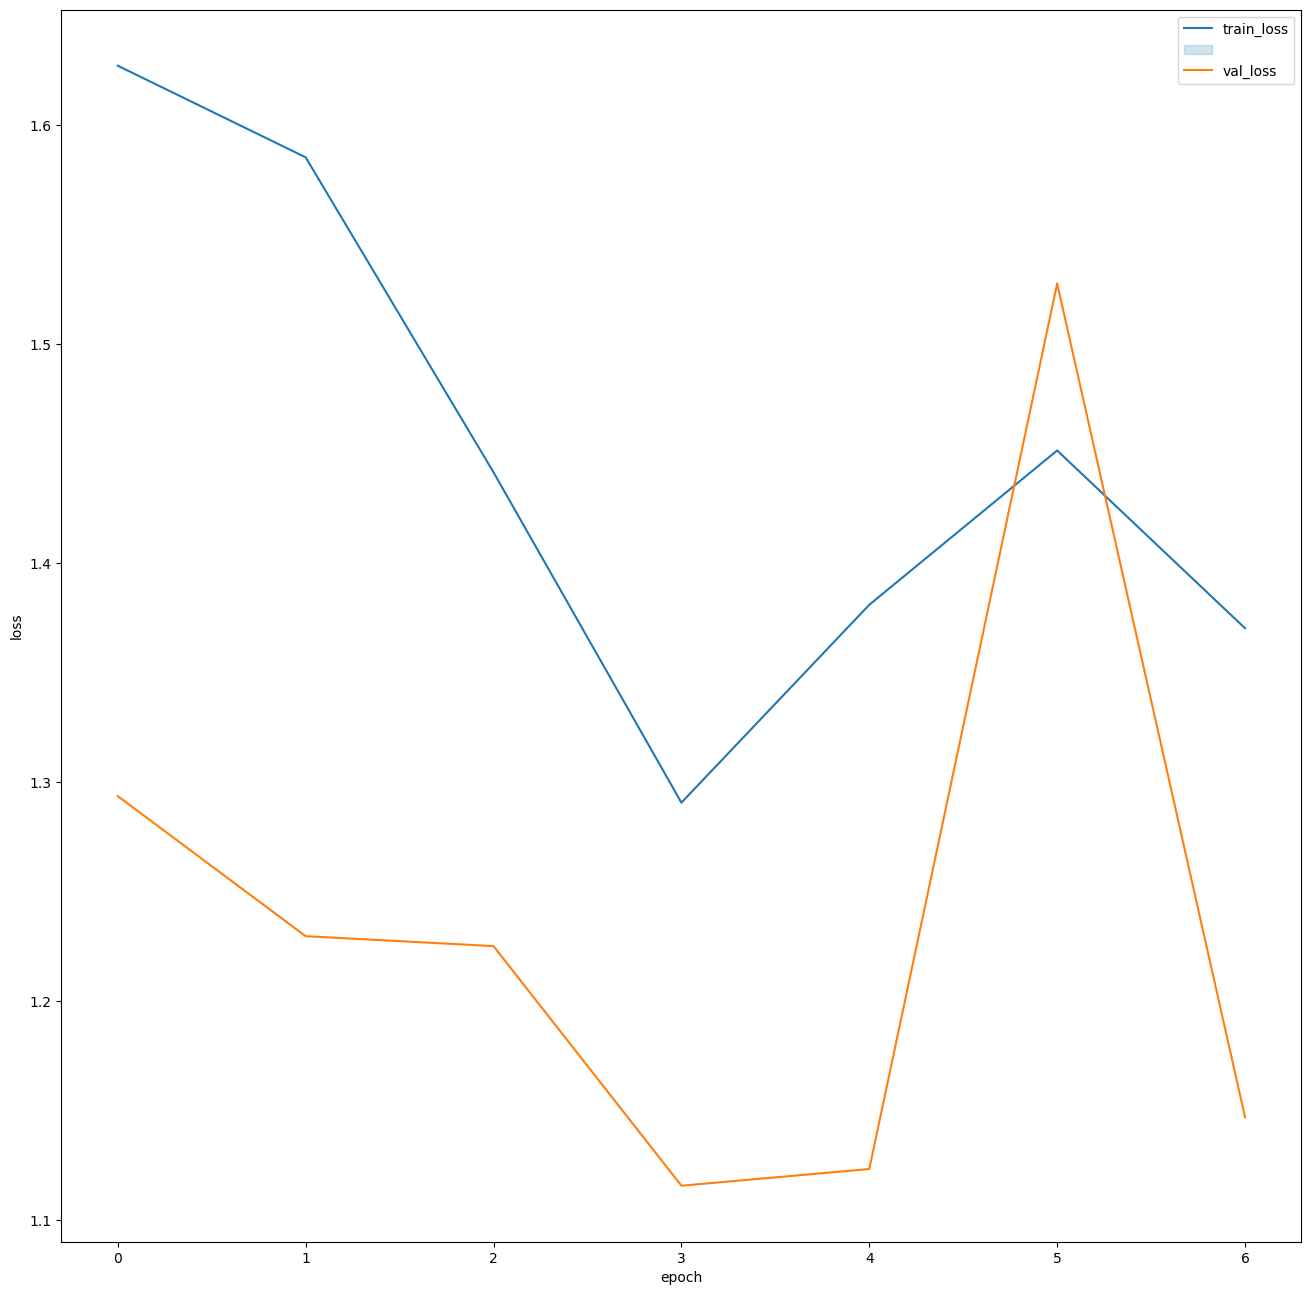

In [42]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
#Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
#Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
#Add legends
plt.legend(labels=['train_loss', '', 'val_loss'])

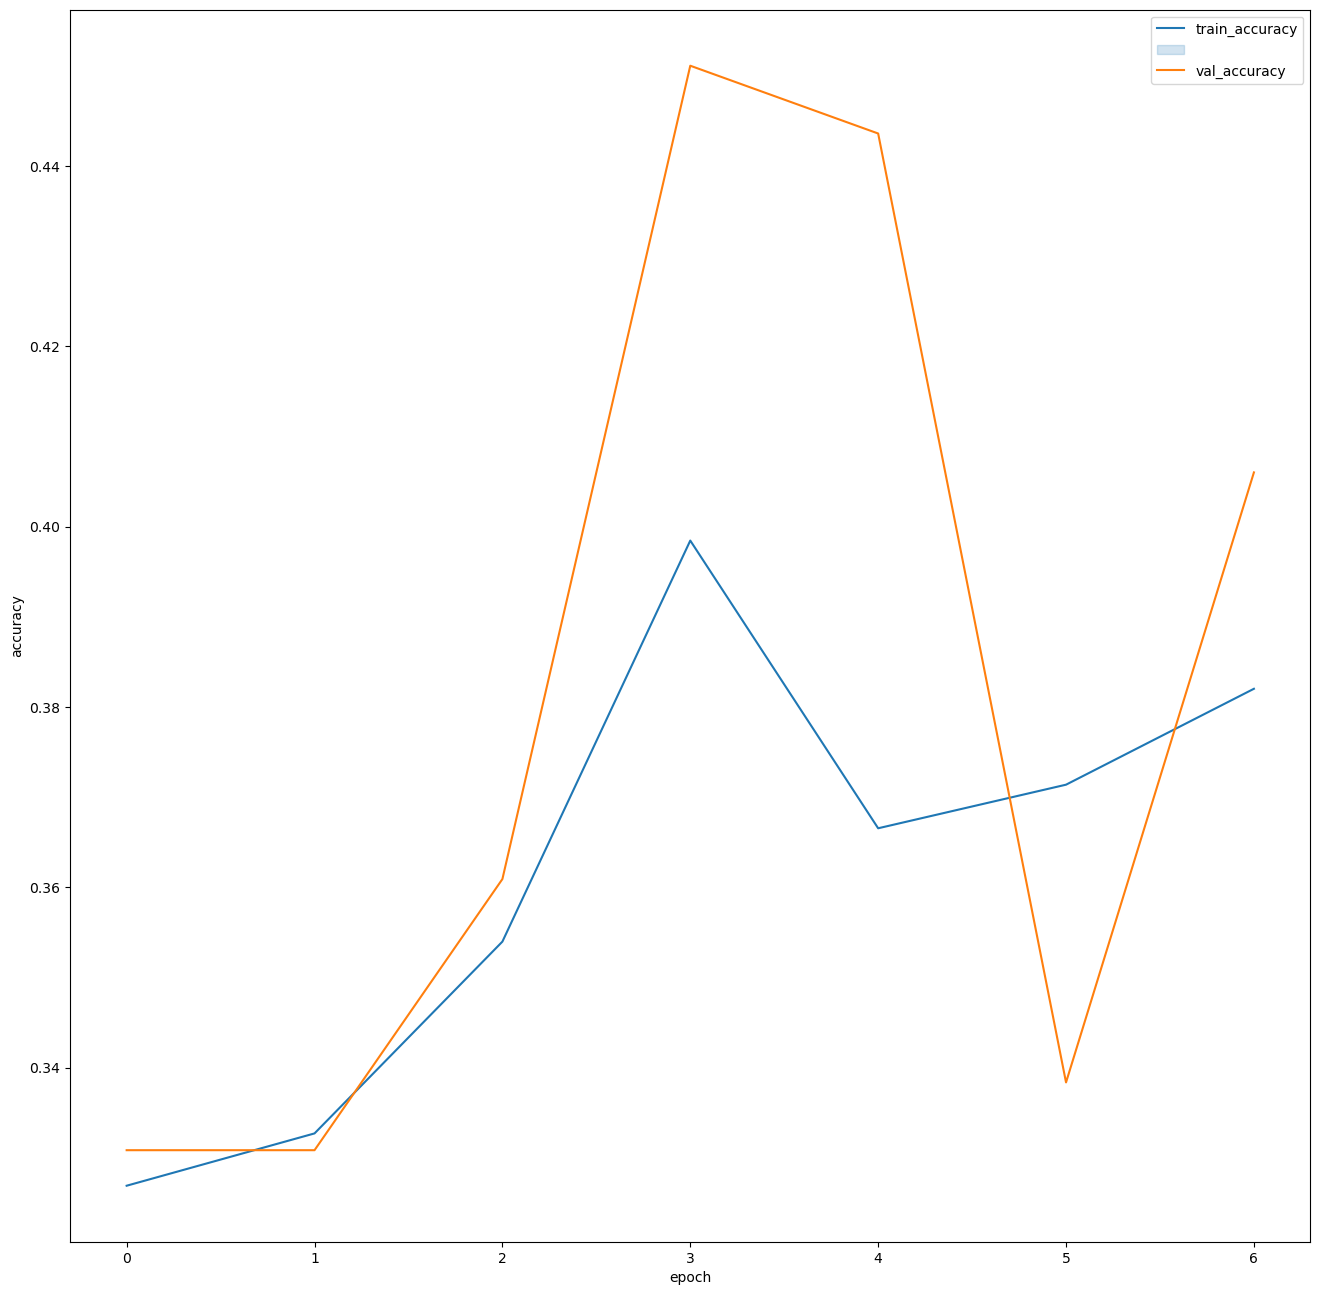

In [43]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
#Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
#Add legends
plt.legend(labels=['train_accuracy', '', 'val_accuracy'])

### Does it produce better performance on the test datasets?

It did perform better on the test datasets, it was scored an accuracy over ten percentage points higher than either of the previous models.